In [5]:
pip install bambi

In [2]:
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import causalpy as cp


import arviz as az
import bambi as bmb
import pandas as pd

import seaborn as sns
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
pd.options.plotting.backend = "plotly"

In [3]:

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.2


In [4]:
df = pd.read_csv("/content/bolig.csv.gzip", compression="gzip", parse_dates=["soldDate"])


In [5]:
#Sorting fam_salg away
alm_salg_df = df[df['saleType'] == 'Alm. Salg']

#Sorting apartments away that where sold for under 500.000 and above 9.000.000
alm_salg_df = alm_salg_df[(alm_salg_df['price'] > 5e5) & (alm_salg_df['price'] < 9e6)]

#Sorting apartments away that have above 5 roomes doe to the likelyhood of it being under 0.001%procent
alm_salg_df = alm_salg_df[(alm_salg_df['rooms'] < 6 )]

In [27]:
# Select only 'price' and 'size' columns
df = alm_salg_df[['price', 'size','rooms']]

In [44]:
df.eq(0, axis=1).sum(axis=1).astype(bool)

0        False
1        False
2        False
4        False
6        False
         ...  
99149    False
99150    False
99151    False
99152    False
99184    False
Length: 68104, dtype: bool

In [81]:
df=(
    df
     .dropna()
      .astype(int)
     .loc[lambda d: ~d.eq(0, axis=1).sum(axis=1).astype(bool)]
     .assign(price_log = lambda d: np.log10(d["price"].values),
             size_log = lambda d: np.log10(d["size"].values))
)

In [82]:
train_index = df.sample(frac=0.8, random_state=42).index

In [83]:
X_train = df[["size_log","rooms"]].loc[lambda d: d.index.isin(train_index)]
y_train = df[["price_log"]].loc[lambda d: d.index.isin(train_index)]

X_train = df[["size_log","rooms"]].loc[lambda d: ~d.index.isin(train_index)]
y_train = df["price_log"].loc[lambda d: ~d.index.isin(train_index)]



In [85]:
10 ** np.log10(10)

10.0

In [88]:
y_train

2        6.540955
14       6.610128
18       6.692406
23       6.681241
34       6.410946
           ...   
99020    6.602060
99031    5.969416
99045    5.977724
99048    5.997561
99053    5.789933
Name: price_log, Length: 13621, dtype: float64

In [98]:
(df
 .astype({"rooms": str})
 .plot(
  kind="scatter", y="price_log", x="size_log", color="rooms", opacity=.5,

           trendline="ols",
           #trendline_scope="overall",
           #trendline_color_override="darkblue",
)
 )

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



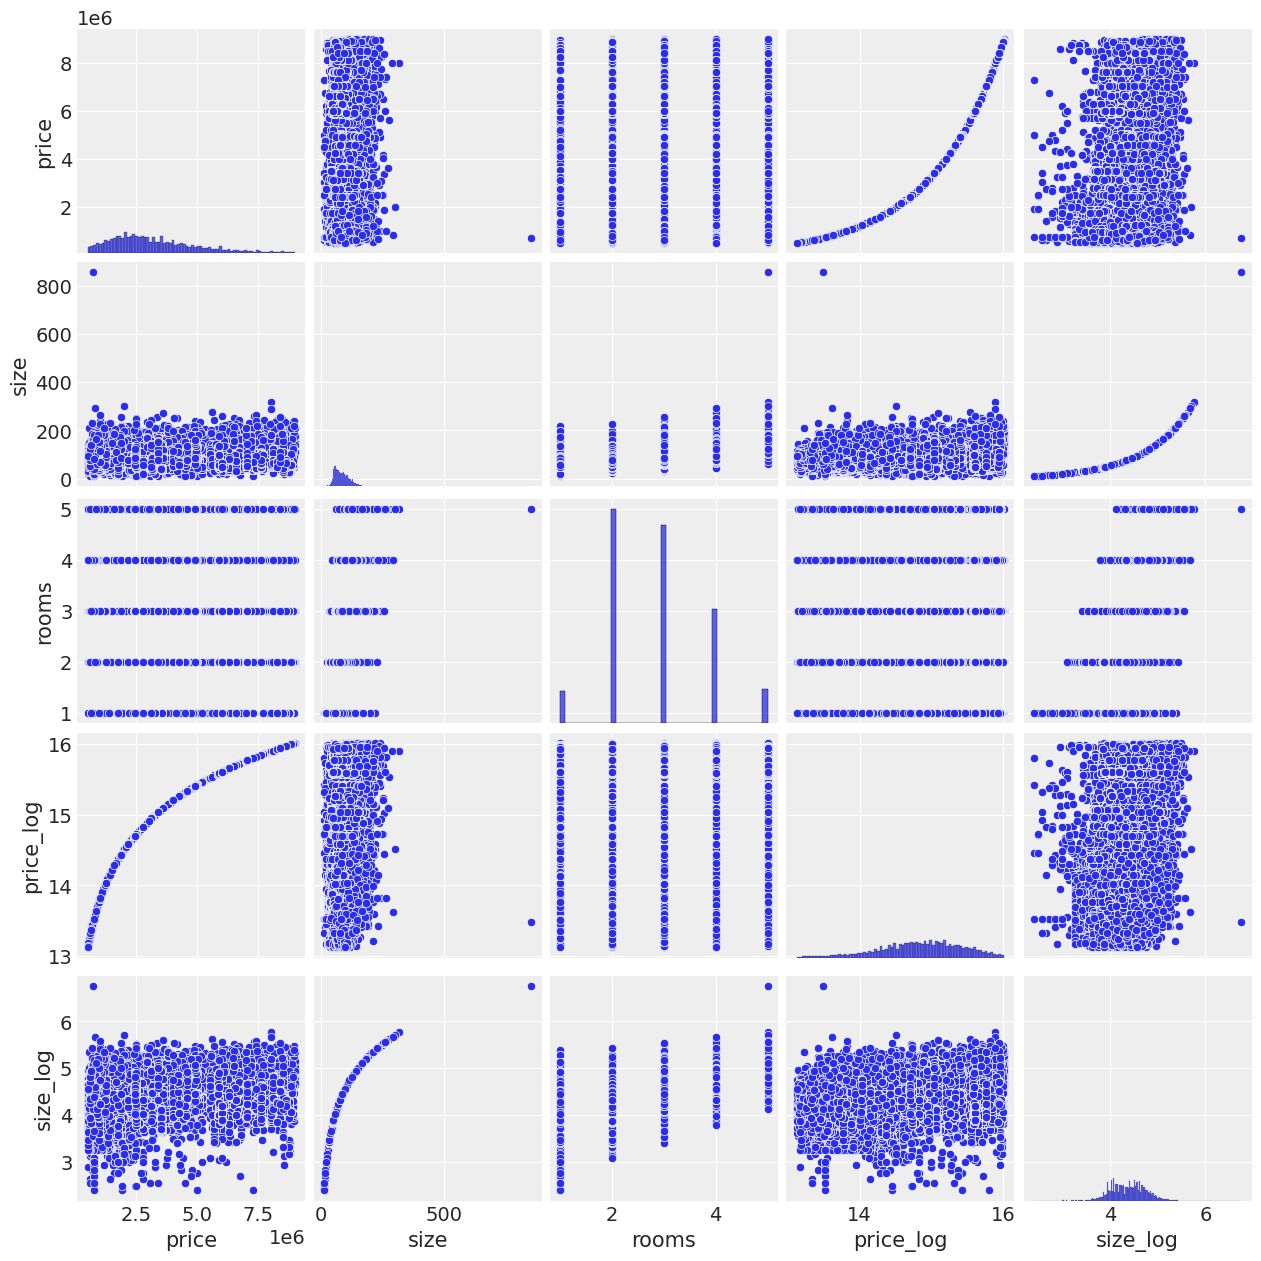

In [74]:
# pairplot
_ = sns.pairplot(data = df)

In [103]:
data = X_train.assign(price_log =  y_train, rooms = y_train)


In [104]:
model = bmb.Model('price_log ~ size_log + (size_log|rooms)', data)

In [105]:
model

       Formula: price_log ~ size_log + (size_log|rooms)
        Family: gaussian
          Link: mu = identity
  Observations: 13621
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 6.4517, sigma: 7.7424)
            size_log ~ Normal(mu: 0.0, sigma: 4.0667)
        
        Group-level effects
            1|rooms ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 7.7424))
            size_log|rooms ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 4.0667))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.2553)

In [ ]:
results = model.fit(draws=1000, chains=4)